<a href="https://colab.research.google.com/github/Riyasingh22600/ml-fundamentals-assignment/blob/main/ch1-2_notes/ch3_numpy_pandas/ch4_eda/ch5_feature_engineering/ch5_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5: Feature Engineering & Selection

---

Original Dataset:
Shape: (2000, 11)
         age        income  education_years  experience  hours_worked  \
0  40.960570  36496.434501               12    1.087349     39.735798   
1  33.340828  47109.626586               15    4.952553     35.970798   
2  42.772262  34151.601580               16    2.463519     38.621000   
3  53.276358  43840.769407               17    5.616033     45.717854   
4  32.190160  25000.000000               12    8.286798     50.222853   

   commute_distance           city  department employment_type satisfaction  \
0          5.812650         Austin   Marketing       Part-time       Medium   
1          1.630812  San Francisco          HR       Part-time       Medium   
2          1.117743  San Francisco  Operations        Contract       Medium   
3          1.485309  San Francisco  Operations       Part-time       Medium   
4         13.115337         Boston     Finance        Contract          Low   

   satisfaction_score  
0            0.511643  
1 

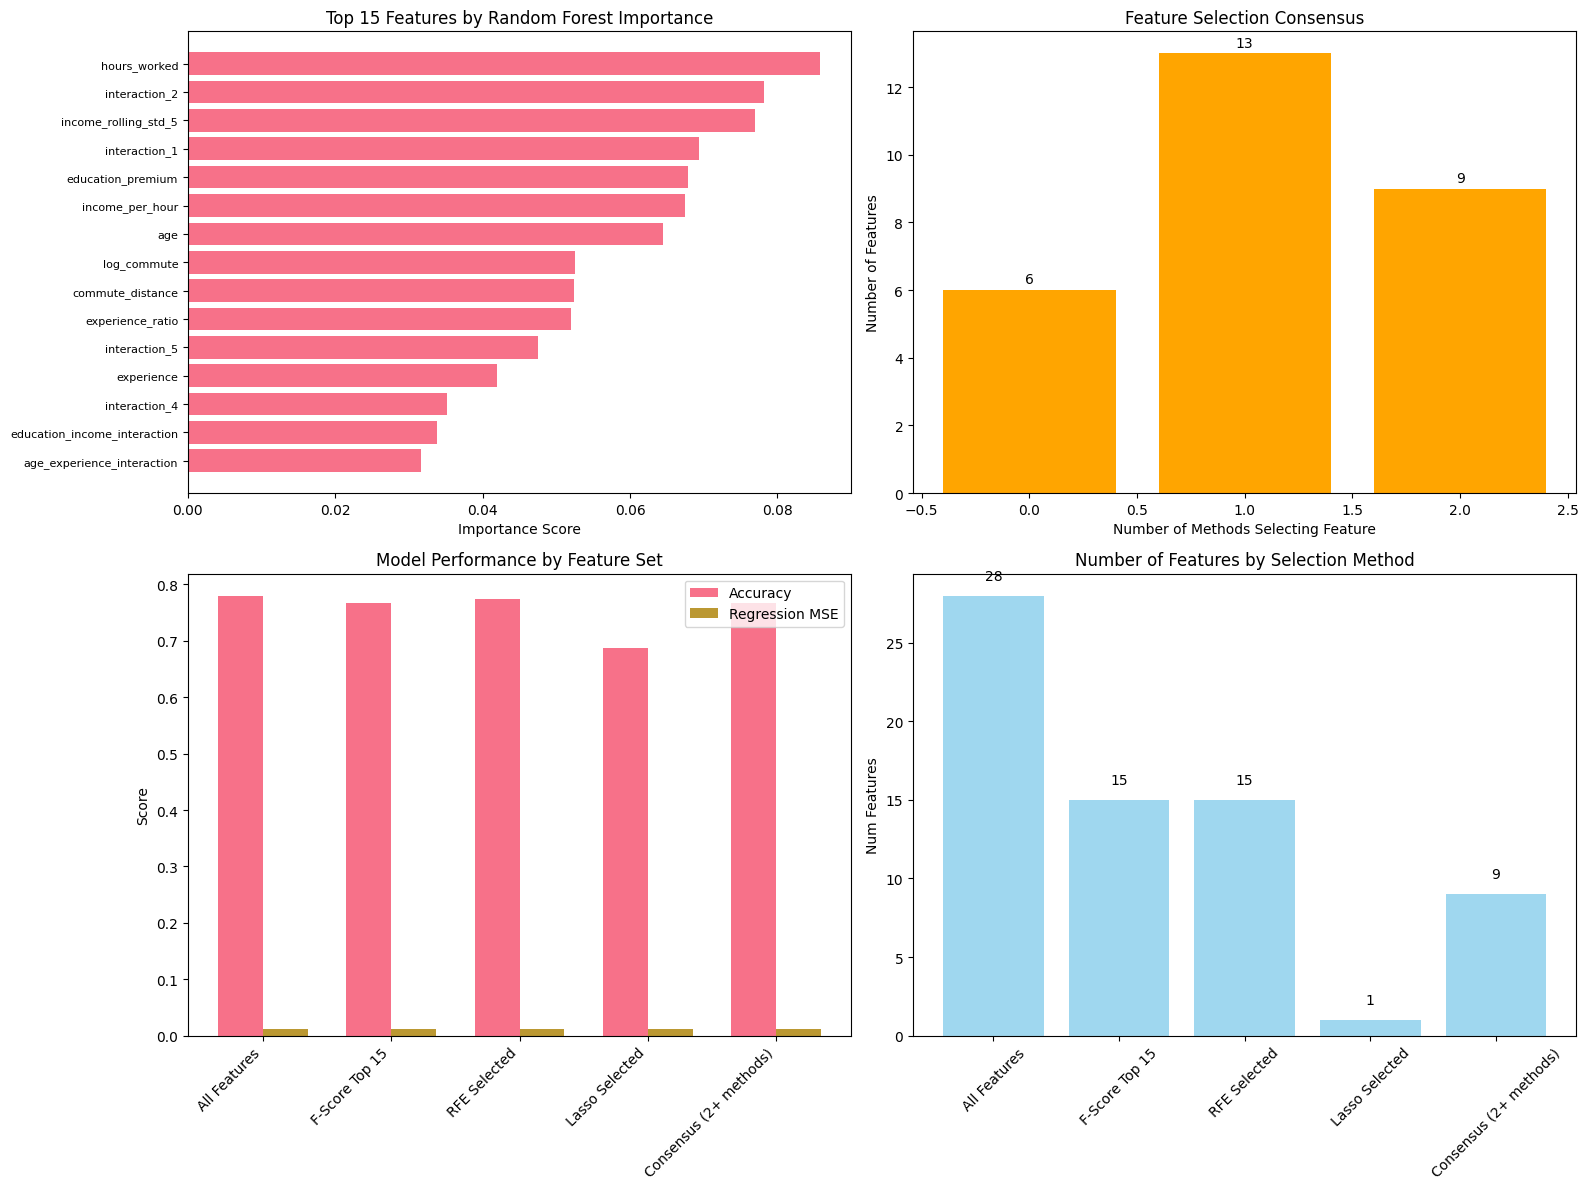


FEATURE ENGINEERING SUMMARY
Original features: 9
After feature engineering: 48
After feature selection (consensus): 9

Best performing method: All Features with 28 features
 - Classification Accuracy: 0.7800
 - Regression MSE: 0.0123

Top 5 most important features (consensus):
1. education_years
2. hours_worked
3. commute_distance
4. education_premium
5. education_income_interaction


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import warnings

warnings.filterwarnings('ignore')
sns.set_palette("husl")

# ==============================
# STEP 0: CREATE SYNTHETIC DATASET
# ==============================

np.random.seed(42)
n_samples = 2000

data = {
    'age': np.random.normal(35, 12, n_samples),
    'income': np.random.normal(50000, 20000, n_samples),
    'education_years': np.random.normal(16, 4, n_samples),
    'experience': np.random.normal(10, 8, n_samples),
    'hours_worked': np.random.normal(40, 8, n_samples),
    'commute_distance': np.random.exponential(15, n_samples),
    'city': np.random.choice(['New York', 'San Francisco', 'Austin', 'Boston', 'Seattle'], n_samples),
    'department': np.random.choice(['IT', 'Finance', 'HR', 'Marketing', 'Operations'], n_samples),
    'employment_type': np.random.choice(['Full-time', 'Part-time', 'Contract'], n_samples)
}

# Clip values to realistic ranges
data['age'] = np.clip(data['age'], 22, 65)
data['income'] = np.clip(data['income'], 25000, 150000)
data['education_years'] = np.clip(data['education_years'], 12, 25).astype(int)
data['experience'] = np.clip(data['experience'], 0, 40)
data['hours_worked'] = np.clip(data['hours_worked'], 20, 60)
data['commute_distance'] = np.clip(data['commute_distance'], 1, 50)

df = pd.DataFrame(data)

# Create target variable: satisfaction
satisfaction_score = (
    0.3 * (df['income'] - df['income'].min()) / (df['income'].max() - df['income'].min()) +
    0.2 * (1 - (df['commute_distance'] - df['commute_distance'].min()) / (df['commute_distance'].max() - df['commute_distance'].min())) +
    0.2 * (1 - abs(df['hours_worked'] - 40)/20) +
    0.1 * (df['education_years'] - df['education_years'].min()) / (df['education_years'].max() - df['education_years'].min()) +
    0.2 * np.random.random(n_samples)
)

df['satisfaction'] = pd.cut(satisfaction_score, bins=3, labels=['Low', 'Medium', 'High'])
df['satisfaction_score'] = satisfaction_score  # continuous version for regression

print("Original Dataset:")
print("="*50)
print(f"Shape: {df.shape}")
print(df.head())

# ==============================
# STEP 1: BASIC FEATURE ENGINEERING
# ==============================

# 1.1 New numerical features
df['income_per_hour'] = df['income'] / (df['hours_worked'] * 52)
df['experience_ratio'] = df['experience'] / df['age']
df['education_premium'] = df['income'] / df['education_years']

df['age_groups'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 65], labels=['Young', 'Mid-Career', 'Senior', 'Elder'])
df['income_quartile'] = pd.qcut(df['income'], q=4, labels=['Q1','Q2','Q3','Q4'])

# 1.2 Interaction features
df['age_experience_interaction'] = df['age'] * df['experience']
df['education_income_interaction'] = df['education_years'] * df['income'] / 1000

# 1.3 Binary features
df['high_earner'] = (df['income'] > df['income'].median()).astype(int)
df['long_commute'] = (df['commute_distance'] > df['commute_distance'].quantile(0.75)).astype(int)
df['overtime_worker'] = (df['hours_worked'] > 45).astype(int)

# 1.4 Domain knowledge categorical feature
def categorize_experience(exp):
    if exp < 2:
        return 'Entry'
    elif exp < 5:
        return 'Junior'
    elif exp < 10:
        return 'Mid'
    else:
        return 'Senior'

df['experience_level'] = df['experience'].apply(categorize_experience)

print(f"After basic feature engineering, shape: {df.shape}")

# ==============================
# STEP 2: ADVANCED FEATURE ENGINEERING
# ==============================

# 2.1 Polynomial interaction features
numerical_for_poly = ['age','income','education_years','experience']
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df[numerical_for_poly])
poly_feature_names = [f"poly_{name}" for name in poly.get_feature_names_out(numerical_for_poly)]
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
interaction_features = [col for col in poly_df.columns if ' ' in col.replace('poly_','')]
for i, feature in enumerate(interaction_features[:5]):
    df[f'interaction_{i+1}'] = poly_df[feature].values

# 2.2 Binning
df['income_bins'] = pd.cut(df['income'], bins=5, labels=['Very Low','Low','Medium','High','Very High'])
df['age_bins'] = pd.cut(df['age'], bins=4, labels=['Young','Adult','Middle','Senior'])

# 2.3 Log transformations
df['log_income'] = np.log(df['income'])
df['log_commute'] = np.log(df['commute_distance'] + 1)

# 2.4 Rolling features
df = df.sort_values('income').reset_index(drop=True)
df['income_rolling_mean_5'] = df['income'].rolling(5, min_periods=1).mean()
df['income_rolling_std_5'] = df['income'].rolling(5, min_periods=1).std().fillna(0)

print(f"After advanced feature engineering, shape: {df.shape}")

# ==============================
# STEP 3: ENCODING CATEGORICAL VARIABLES
# ==============================

# Label encoding for ordinal
ordinal_features = ['age_groups','income_quartile','experience_level','income_bins','age_bins']
label_encoders = {}
for feature in ordinal_features:
    le = LabelEncoder()
    df[f'{feature}_encoded'] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

# One-hot encoding for nominal
nominal_features = ['city','department','employment_type']
df_encoded = pd.get_dummies(df, columns=nominal_features, prefix=nominal_features)

print(f"After encoding, shape: {df_encoded.shape}")

# ==============================
# STEP 4: FEATURE SCALING
# ==============================

numerical_features = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if 'satisfaction' not in col]

X = df_encoded[numerical_features]
y_classification = df_encoded['satisfaction']
y_regression = df_encoded['satisfaction_score']

X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)
_, _, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f"Scaled training shape: {X_train_scaled.shape}, test shape: {X_test_scaled.shape}")

# ==============================
# STEP 5: FEATURE SELECTION
# ==============================

# Filter method: F-score
selector_f = SelectKBest(score_func=f_regression, k=15)
X_train_selected_f = selector_f.fit_transform(X_train_scaled, y_train_reg)
feature_scores = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'score': selector_f.scores_,
    'selected': selector_f.get_support()
}).sort_values('score', ascending=False)
print("Top 10 features by F-score:")
print(feature_scores.head(10)[['feature','score']])

# Wrapper method: RFE
rf_selector = RandomForestClassifier(n_estimators=50, random_state=42)
rfe = RFE(rf_selector, n_features_to_select=15)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train_class)
rfe_features = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'selected': rfe.support_,
    'ranking': rfe.ranking_
}).sort_values('ranking')
print("RFE selected features:")
print(rfe_features[rfe_features['selected']][['feature','ranking']])

# Embedded method: Random Forest importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_reg)
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print("Top 15 features by Random Forest importance:")
print(feature_importance.head(15))

# Lasso selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train_reg)
lasso_features = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': lasso.coef_,
    'abs_coefficient': np.abs(lasso.coef_)
})
selected_by_lasso = lasso_features[lasso_features['abs_coefficient'] > 0]
print("Top 10 Lasso-selected features:")
print(selected_by_lasso.head(10))

# ==============================
# STEP 6: FEATURE SELECTION COMPARISON
# ==============================

methods_comparison = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'f_score_selected': selector_f.get_support(),
    'rfe_selected': rfe.support_,
    'rf_importance': rf.feature_importances_,
    'lasso_selected': np.abs(lasso.coef_)>0
})
methods_comparison['selection_count'] = (
    methods_comparison['f_score_selected'].astype(int) +
    methods_comparison['rfe_selected'].astype(int) +
    methods_comparison['lasso_selected'].astype(int)
)
consensus_features = methods_comparison[methods_comparison['selection_count'] >= 2].sort_values('selection_count', ascending=False)
print("Consensus features (selected by 2+ methods):")
print(consensus_features[['feature','selection_count','rf_importance']])
# ==============================
# STEP 7: MODEL PERFORMANCE COMPARISON
# ==============================

from matplotlib.ticker import MaxNLocator

def evaluate_feature_set(X_train_subset, X_test_subset, feature_set_name):
    # Classification
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_subset, y_train_class)
    y_pred_class = clf.predict(X_test_subset)
    class_accuracy = accuracy_score(y_test_class, y_pred_class)

    # Regression
    reg = RandomForestRegressor(n_estimators=100, random_state=42)
    reg.fit(X_train_subset, y_train_reg)
    y_pred_reg = reg.predict(X_test_subset)
    reg_mse = mean_squared_error(y_test_reg, y_pred_reg)

    return class_accuracy, reg_mse

# Define different feature sets
feature_sets = {
    'All Features': X_train_scaled,
    'F-Score Top 15': X_train_scaled.iloc[:, selector_f.get_support()],
    'RFE Selected': X_train_scaled.iloc[:, rfe.support_],
    'Lasso Selected': X_train_scaled.iloc[:, np.abs(lasso.coef_)>0],
    'Consensus (2+ methods)': X_train_scaled[consensus_features['feature'].tolist()]
}

performance_results = []

for name, feature_set in feature_sets.items():
    if feature_set.shape[1] > 0:  # Ensure we have features
        class_acc, reg_mse = evaluate_feature_set(feature_set, X_test_scaled[feature_set.columns], name)
        performance_results.append({
            'Method': name,
            'Num_Features': feature_set.shape[1],
            'Classification_Accuracy': class_acc,
            'Regression_MSE': reg_mse
        })

results_df = pd.DataFrame(performance_results)
print("\nModel Performance Comparison:")
print(results_df)

# ==============================
# VISUALIZATION
# ==============================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top features by Random Forest importance
top_features = feature_importance.head(15)
axes[0, 0].barh(range(len(top_features)), top_features['importance'])
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'], fontsize=8)
axes[0, 0].invert_yaxis()
axes[0, 0].set_title('Top 15 Features by Random Forest Importance')
axes[0, 0].set_xlabel('Importance Score')

# 2. Feature selection consensus
selection_counts = methods_comparison['selection_count'].value_counts().sort_index()
axes[0, 1].bar(selection_counts.index, selection_counts.values, color='orange')
axes[0, 1].set_title('Feature Selection Consensus')
axes[0, 1].set_xlabel('Number of Methods Selecting Feature')
axes[0, 1].set_ylabel('Number of Features')
for i, v in enumerate(selection_counts.values):
    axes[0, 1].text(selection_counts.index[i], v + 0.2, str(v), ha='center')

# 3. Model performance comparison
x_pos = np.arange(len(results_df))
width = 0.35
axes[1, 0].bar(x_pos - width/2, results_df['Classification_Accuracy'], width, label='Accuracy')
axes[1, 0].bar(x_pos + width/2, results_df['Regression_MSE'], width, label='Regression MSE')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(results_df['Method'], rotation=45, ha='right')
axes[1, 0].set_title('Model Performance by Feature Set')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()

# 4. Number of features by method
axes[1, 1].bar(results_df['Method'], results_df['Num_Features'], color='skyblue', alpha=0.8)
axes[1, 1].set_title('Number of Features by Selection Method')
axes[1, 1].set_ylabel('Num Features')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(results_df['Num_Features']):
    axes[1, 1].text(i, v + 1, str(v), ha='center')

plt.tight_layout()
plt.show()

# ==============================
# FINAL SUMMARY
# ==============================

print("\nFEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"Original features: {len(data.keys())}")
print(f"After feature engineering: {len(df_encoded.columns)}")
print(f"After feature selection (consensus): {len(consensus_features)}")

# Best performing method
best_method = results_df.loc[results_df['Classification_Accuracy'].idxmax()]
print(f"\nBest performing method: {best_method['Method']} with {best_method['Num_Features']} features")
print(f" - Classification Accuracy: {best_method['Classification_Accuracy']:.4f}")
print(f" - Regression MSE: {best_method['Regression_MSE']:.4f}")

# Top consensus features
top_consensus = consensus_features.head(5)['feature'].tolist()
print("\nTop 5 most important features (consensus):")
for i, feature in enumerate(top_consensus, 1):
    print(f"{i}. {feature}")
